본 강좌에서는 간단한 컨볼루션 신경망 모델을 만들어봅니다. 늘 그렇듯이 다음과 같은 순서로 진행하겠습니다.

1. 문제 정의하기
1. 데이터셋 준비하기
1. 모델 구성하기
1. 모델 엮기
1. 모델 학습시키기
1. 모델 사용하기

---

### 문제 정의하기

좋은 예제와 그와 관련된 데이터셋도 공개된 것이 많이 있지만, 직접 문제를 정의하고 데이터를 만들어보는 것도 처럼 딥러닝을 접하시는 분들에게는 크게 도움이 될 것 같습니다. 컨볼루션 신경망 모델에 적합한 문제는 이미지 기반의 분류입니다. 따라서 우리는 직접 손으로 삼각형, 사각형, 원을 그려 이미지로 저장한 다음 이를 분류해보는 모델을 만들어보겠습니다. 문제 형태와 입출력을 다음과 같이 정의해봅니다.
* 문제 형태 : 다중 클래스 분류
* 입력 : 손으로 그린 삼각형, 사각형, 원 이미지
* 출력 : 삼각형, 사각형, 원일 확률을 나타내는 벡터

매번 실행 시마다 결과가 달라지지 않도록 랜덤 시드를 명시적으로 지정합니다.

In [1]:
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(3)

---

### 데이터셋 준비하기

손으로 그린 삼각형, 사각형, 원 이미지를 만들기 위해서는 여러가지 방법이 있을 수 있겠네요. 테블릿을 이용할 수도 있고, 종이에 그려서 사진으로 찍을 수도 있습니다. 저는 그림 그리는 툴을 이용해서 만들어봤습니다. 이미지 사이즈는 24 x 24 정도로 해봤습니다. 

![data](http://tykimos.github.com/Keras/warehouse/2017-3-8_CNN_Getting_Started_1.png)

모양별로 20개 정도를 만들어서 15개를 훈련에 사용하고, 5개를 테스트에 사용해보겠습니다. 이미지는 png나 jpg로 저장합니다. 실제로 데이터셋이 어떻게 구성되어 있는 지 모른 체 튜토리얼을 따라하거나 예제 코드를 실행시키다보면 결과는 잘 나오지만 막상 실제 문제에 적용할 때 막막해질 때가 있습니다. 간단한 예제로 직접 데이터셋을 만들어봄으로써 실제 문제에 접근할 때 시행착오를 줄이는 것이 중요합니다.

데이터셋 폴더는 다음과 같이 구성했습니다.

- train
 - circle
 - rectangle
 - triangle
- validation
 - circle
 - rectangle
 - triangle
 
![data](http://tykimos.github.com/Keras/warehouse/2017-3-8_CNN_Getting_Started_2.png)


---

### 데이터셋 불러오기

케라스에서는 이미지 파일을 쉽게 학습시킬 수 있도록 ImageDataGenerator 클래스를 제공합니다. ImageDataGenerator 클래스는 데이터 증강 (data augmentation)을 위해 막강한 기능을 제공하는 데, 이 기능들은 다른 강좌에세 다루기로 하고, 본 강좌에서는 특정 폴더에 이미지를 분류 해놓았을 때 이를 학습시키기 위한 데이터셋으로 만들어주는 기능을 사용해보겠습니다.

먼저 ImageDataGenerator 클래스를 이용하여 객체를 생성한 뒤 flow_from_directory() 함수를 호출하여 제네레이터(generator)를 생성합니다. flow_from_directory() 함수의 주요인자는 다음과 같습니다.

- 첫번재 인자 : 이미지 경로를 지정합니다.
- target_size : 패치 이미지 크기를 지정합니다. 폴더에 있는 원본 이미지 크기가 다르더라도 target_size에 지정된 크기로 자동 조절됩니다.
- batch_size : 배치 크기를 지정합니다.
- class_mode : 분류 방식에 대해서 지정합니다.
    - categorical : 2D one-hot 부호화된 라벨이 반환됩니다.
    - binary : 1D 이진 라벨이 반환됩니다.
    - sparse : 1D 정수 라벨이 반환됩니다.
    - None : 라벨이 반환되지 않습니다.

본 예제에서는 패치 이미지 크기를 24 x 24로 하였으니 target_size도 (24, 24)로 셋팅하였습니다. 훈련 데이터 수가 클래스당 15개이니 배치 크기를 3으로 지정하여 총 5번 배치를 수행하면 하나의 epoch가 수행될 수 있도록 하였습니다. 다중 클래스 문제이므로 class_mode는 'categorical'로 지정하였습니다. 그리고 제네레이터는 훈련용과 검증용으로 두 개를 만들었습니다. 

In [2]:
from keras.preprocessing.image import ImageDataGenerator

# 데이터셋 불러오기
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'warehouse/handwriting_shape/train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'warehouse/handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical')

Found 45 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


Using Theano backend.


---

### 모델 구성하기

영상 분류에 높은 성능을 보이고 있는 컨볼루션 신경망 모델을 구성해보겠습니다. 이전 강좌에서 만들어봤던 모델 위에 입력을 24 x 24, 3개 채널 이미지를 받을 수 있고 필터를 12개를 가진 컨볼루션 레이어와 맥스풀링 레이어를 추가해봤습니다.

* 컨볼루션 레이어 : 입력 이미지 크기 24 x 24, 입력 이미지 채널 3개, 필터 크기 3 x 3, 필터 수 12개, 경계 타입 'same', 활성화 함수 'relu'
* 맥스풀링 레이어 : 풀 크기 2 x 2
* 컨볼루션 레이어 : 입력 이미지 크기 8 x 8, 입력 이미지 채널 1개, 필터 크기 3 x 3, 필터 수 2개, 경계 타입 'same', 활성화 함수 'relu'
* 맥스풀링 레이어 : 풀 크기 2 x 2
* 컨볼루션 레이어 : 입력 이미지 크기 4 x 4, 입력 이미지 채널 2개, 필터 크기 2 x 2, 필터 수 3개, 경계 타입 'same', 활성화 함수 'relu'
* 맥스풀링 레이어 : 풀 크기 2 x 2
* 플래튼 레이어
* 댄스 레이어 : 입력 뉴런 수 12개, 출력 뉴런 수 8개, 활성화 함수 'relu'
* 댄스 레이어 : 입력 뉴런 수 8개, 출력 뉴런 수 3개, 활성화 함수 'softmax'

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

# 모델 구성하기
'''
model = Sequential()
model.add(Conv2D(12, (5, 5), padding='same', activation='relu', input_shape=(24, 24, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(4, (2, 2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))
'''

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

'''
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(24,24,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
'''

"\nmodel = Sequential()\nmodel.add(Conv2D(32, kernel_size=(3, 3),\n                 activation='relu',\n                 input_shape=(24,24,3)))\nmodel.add(Conv2D(64, (3, 3), activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\nmodel.add(Flatten())\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(3, activation='softmax'))\n"

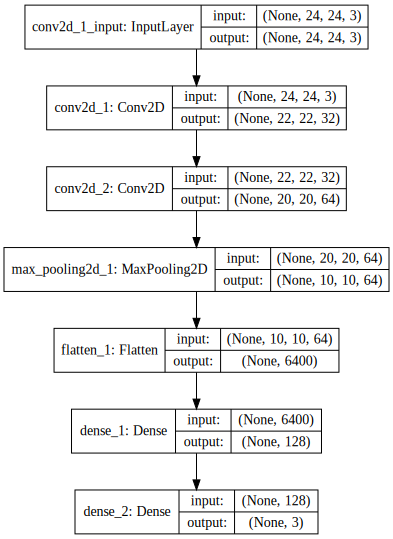

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

![model](http://tykimos.github.com/Keras/warehouse/2017-3-8_CNN_Getting_Started_3.png)

---

### 모델 엮기

모델을 정의했다면 모델을 손실함수와 최적화 알고리즘으로 엮어봅니다. 
- loss : 현재 가중치 세트를 평가하는 데 사용한 손실 함수 입니다. 다중 클래스 문제이므로 'categorical_crossentropy'으로 지정합니다.
- optimizer : 최적의 가중치를 검색하는 데 사용되는 최적화 알고리즘으로 효율적인 경사 하강법 알고리즘 중 하나인 'adam'을 사용합니다.
- metrics : 평가 척도를 나타내며 분류 문제에서는 일반적으로 'accuracy'으로 지정합니다.

In [5]:
# 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 모델 학습시키기

케라스에서는 모델을 학습시킬 때 주로 fit 함수를 사용하지만 제네레이터로 생성된 배치로 학습시킬 경우에는 fit_generator 함수를 사용합니다. 본 예제에서는 ImageDataGenerator라는 제네레이터로 이미지를 담고 있는 배치로 학습시키기 때문에 fit_generator 함수를 사용하겠습니다.

- 첫번째 인자 : 훈련데이터셋을 제공할 제네레이터를 지정합니다. 본 예제에서는 앞서 생성한 train_generator으로 지정합니다.
- samples_per_epoch : 한 epoch에 사용한 샘플 수를 지정합니다. 총 45개의 훈련 샘플이 있으므로 45로 지정합니다.
- nb_epoch : 전체 훈련 데이터셋에 대해 학습 반복 횟수를 지정합니다. 100번을 반복적으로 학습시켜 보겠습니다.
- validation_data : 검증데이터셋을 제공할 제네레이터를 지정합니다. 본 예제에서는 앞서 생성한 validation_generator으로 지정합니다.
- nb_val_samples : 한 epoch 종료 시 마다 검증할 때 사용되는 검증 샘플 수를 지정합니다. 홍 15개의 검증 샘플이 있으므로 15로 지정합니다.

In [6]:
# 모델 학습시키기
model.fit_generator(
        train_generator,
        steps_per_epoch=45,
        epochs=50,
        validation_data=test_generator,
        validation_steps=15)

Epoch 1/50
45/45 [==============================] - 0s - loss: 0.3770 - acc: 0.8593 - val_loss: 0.0174 - val_acc: 1.0000
Epoch 2/50
45/45 [==============================] - 0s - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 3/50
45/45 [==============================] - 0s - loss: 2.0370e-04 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 4/50
45/45 [==============================] - 0s - loss: 1.3494e-04 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 5/50
45/45 [==============================] - 0s - loss: 9.9046e-05 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 6/50
45/45 [==============================] - 0s - loss: 7.6299e-05 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 7/50
45/45 [==============================] - 0s - loss: 5.7012e-05 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 8/50
45/45 [==============================] - 0s - loss: 4.4549e-05 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 9/

---

### 모델 사용하기

학습한 모델을 평가해봅니다. 제네레이터에서 제공되는 샘플로 평가할 때는 evaluate_generator 함수를 사용하고, 예측할 때는 predict_generator 함수를 사용합니다. 

In [7]:
# 모델 평가하기
print("-- Evaluate --")

scores = model.evaluate_generator(
            test_generator, 
            steps = 15)

print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 모델 예측하기
print("-- Predict --")

output = model.predict_generator(
            test_generator, 
            steps = 15)

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(output)

-- Evaluate --
acc: 100.00%
-- Predict --
[[1.000 0.000 0.000]
 [0.000 0.000 1.000]
 [0.000 1.000 0.000]
 [0.999 0.000 0.001]
 [0.000 1.000 0.000]
 [0.000 0.000 1.000]
 [0.000 0.000 1.000]
 [0.007 0.965 0.028]
 [1.000 0.000 0.000]
 [0.000 1.000 0.000]
 [0.000 0.000 1.000]
 [0.000 1.000 0.000]
 [0.000 0.001 0.999]
 [1.000 0.000 0.000]
 [1.000 0.000 0.000]
 [0.999 0.000 0.001]
 [0.000 1.000 0.000]
 [0.000 0.000 1.000]
 [0.000 1.000 0.000]
 [0.000 1.000 0.000]
 [1.000 0.000 0.000]
 [1.000 0.000 0.000]
 [0.007 0.965 0.028]
 [0.000 0.000 1.000]
 [1.000 0.000 0.000]
 [0.000 0.001 0.999]
 [1.000 0.000 0.000]
 [0.000 0.000 1.000]
 [0.000 1.000 0.000]
 [0.000 0.000 1.000]
 [1.000 0.000 0.000]
 [1.000 0.000 0.000]
 [1.000 0.000 0.000]
 [1.000 0.000 0.000]
 [0.000 1.000 0.000]
 [0.007 0.965 0.028]
 [0.000 1.000 0.000]
 [0.000 0.000 1.000]
 [0.000 0.000 1.000]
 [0.000 0.000 1.000]
 [0.000 1.000 0.000]
 [0.000 0.000 1.000]
 [0.000 1.000 0.000]
 [0.999 0.000 0.001]
 [0.000 0.001 0.999]]


간단한 모델이고 데이터셋이 적은 데도 불구하고 93.33%라는 높은 정확도를 얻었습니다. 개수로 따지면 검증 샘플 15개 중 1개가 잘 못 분류가 되었네요. Predict 함수는 입력된 이미지에 대해서 모델의 결과를 알려주는 역할을 하는 데, 각 샘플별로 클래스별 확률을 확인할 수 있습니다. 각 열은 다음을 뜻합니다.
- 첫번째 열 : 원일 확률
- 두번째 열 : 사각형일 확률
- 세번째 열 : 삼각형일 확률

확인을 해보니 rectangle020.png 파일이 사격형이 아니라 삼각형으로 판정이 되었습니다. 사각형을 그릴 때는 몰랐었는데, 막상 모델에서 삼각형이라고 얘기하니 다른 사각형이랑 조금 다르게 그린 것 같습니다.

![predict](http://tykimos.github.com/Keras/warehouse/2017-3-8_CNN_Getting_Started_4.png)


---

### 전체 소스

In [8]:
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(3)

from keras.preprocessing.image import ImageDataGenerator

# 데이터셋 불러오기
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'warehouse/handwriting_shape/train',
        target_size=(24, 24),
        batch_size=3,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'warehouse/handwriting_shape/test',
        target_size=(24, 24),    
        batch_size=3,
        class_mode='categorical')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

# 모델 구성하기
model = Sequential()
model.add(Conv2D(12, (5, 5), padding='same', activation='relu', input_shape=(24, 24, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(4, (2, 2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

# 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습시키기
model.fit_generator(
        train_generator,
        steps_per_epoch=45,
        epochs=200,
        validation_data=test_generator,
        validation_steps=15)

# 모델 평가하기
print("-- Evaluate --")

scores = model.evaluate_generator(
            test_generator, 
            steps = 15)

print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 모델 예측하기
print("-- Predict --")

output = model.predict_generator(
            test_generator, 
            steps = 15)

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(output)

Found 45 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Epoch 1/200
45/45 [==============================] - 0s - loss: 1.0422 - acc: 0.3407 - val_loss: 0.9623 - val_acc: 0.3333
Epoch 2/200
45/45 [==============================] - 0s - loss: 0.8505 - acc: 0.5407 - val_loss: 0.7160 - val_acc: 0.8444
Epoch 3/200
45/45 [==============================] - 0s - loss: 0.4575 - acc: 0.9481 - val_loss: 0.3764 - val_acc: 0.9111
Epoch 4/200
45/45 [==============================] - 0s - loss: 0.1531 - acc: 1.0000 - val_loss: 0.3294 - val_acc: 0.8889
Epoch 5/200
45/45 [==============================] - 0s - loss: 0.0725 - acc: 1.0000 - val_loss: 0.2637 - val_acc: 0.9333
Epoch 6/200
45/45 [==============================] - 0s - loss: 0.0327 - acc: 1.0000 - val_loss: 0.3919 - val_acc: 0.9111
Epoch 7/200
45/45 [==============================] - 0s - loss: 0.0169 - acc: 1.0000 - val_loss: 0.4626 - val_acc: 0.9111
Epoch 8/200
45/45 [==============================] - 0s - loss: 0.

---

### 결론

본 강좌에서는 이미지 분류 문제를 직접 정의해보고 데이터셋도 직접 만들어봤습니다. 이미지 분류 문제에 높은 성능을 보이고 있는 컨볼루션 신경망 모델을 이용하여 직접 만든 데이터셋으로 학습 및 평가를 해보았습니다. 학습 결과는 좋게 나왔지만 이 모델은 한 사람이 그린 것에 대해서만 학습이 되어 있어서 다른 사람에 그린 모양은 잘 분류를 못할 것 같습니다. 이후 강좌에서는 다른 사람이 그린 모양으로 평가해보고 어떻게 모델 성능을 높일 수 있을 지 알아보겠습니다.

그리고 실제 문제에 적용하기 전에 데이터셋을 직접 만들어보거나 좀 더 쉬운 문제로 추상화해서 프로토타이핑 하시는 것을 권장드립니다. 객담도말된 결핵 이미지 판별하는 모델을 만들 때, 결핵 이미지를 바로 사용하지 않고, MNIST의 손글씨 중 '1'과 '7'을 결핵이라고 보고, 나머지는 결핵이 아닌 것으로 학습시켜봤었습니다. 결핵균이 간균 (막대모양)이라 적절한 프로토타이핑이었습니다. 

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/Keras/lecture/)
* 이전 : [딥러닝 모델 이야기/컨볼루션 신경망 레이어 이야기](https://tykimos.github.io/Keras/2017/01/27/CNN_Layer_Talk/)
* 다음 : [딥러닝 모델 이야기/순환 신경망 레이어 이야기]